In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

# Define model and create sample trajectory

In [3]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            
gIh   = 1/14
gIc   = 1/14
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter
fh = 0.1 
gE    = 1/5
gA    = 1/3

hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC
sa = 0  # change in the population, not taken into account by inference at the moment 

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])   # and also symptomatic infectives
R0  = np.zeros((M))
E0  = np.array([100, 100])
A0  = np.array([100, 100])
Ih0  = np.array([5, 5])
Ic0  = np.array([5, 5])
Im0  = np.array([5, 5])
S0  = Ni - (Ia0+Is0+R0+E0+A0+Ih0+Ic0+Im0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}

# use pyross stochastic to generate traj and save 
# sto_model = pyross.stochastic.SEAI5R(parameters, M, Ni)
# data = sto_model.simulate(S0, E0, A0, Ia0, Is0, Ih0, Ic0, Im0, contactMatrix, Tf, Nf)
# data_array = data['X']
# np.save('SEAI5R_traj.npy', data_array)

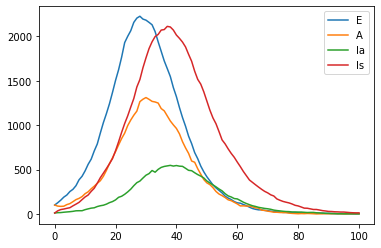

In [14]:
# plot the stochastic solution 
# plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='E')
plt.plot(data_array[:, 2*M], label='A')
plt.plot(data_array[:, 3*M], label='Ia')
plt.plot(data_array[:, 4*M], label='Is')

plt.legend()
plt.show()

# Infer parameters based on part of the trajectory

In [9]:
# load the data and rescale to intensive variables 
Tf_inference = 30 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1

x = np.load('SEAI5R_traj.npy').astype('float')
x = (x[:,:8*M]/N)[:Nf_inference]
steps = 101 # number internal integration steps taken


# initialise the estimator 
estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)

## create filter to distinguish between observable classes
fltr=np.repeat(np.array([False, False, False, False, True, True, True, True]), M)
obs=x[:,fltr]
x0 = x[0]

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-2135.9154054369187
1.1670818328857422


In [28]:
alpha_g = 0.3          ## bad initial guess
alpha_std = 0.1 
alpha_b = (0.1,0.5)

beta_g  = 0.03         ## bad initial guess
beta_std = 0.1 
beta_b = (1e-3, 1)

gIa_g   = 1./7    
gIa_std = 0.1 
gIa_b = (0.01, 1)

gIs_g   = 1./7 
gIs_std = 0.1 
gIs_b = (0.01, 1)

gE_g    = 0.2
gE_std = 0.05 
gE_b = (0.01, 1)

gA_g    = 0.3 
gA_std = 0.1 
gA_b = (0.01, 1) 
   

E0_g = E0/N 
E_std = E0_g*0.4 
bounds_for_E = np.tile([0.1/N, 100/N], M).reshape(M, 2)

A0_g = A0/N 
A_std = A0_g*0.4 
bounds_for_A = np.tile([0.1/N, 100/N], M).reshape(M, 2)

Ia0_g = Ia0/N
Ia_std = Ia0_g*0.4 
bounds_for_Ia = np.tile([0.1/N, 100/N], M).reshape(M, 2)

Is0_g = Is0/N 
Is_std = Is0_g*0.2 
bounds_for_Is = np.tile([0.1/N, 100/N], M).reshape(M, 2)

Ih0_g = (Ih0+1)/N
Ih_std = [1/N]*M 
bounds_for_Ih = np.tile([0.1/N, 10/N], M).reshape(M, 2)

Ih0_g = (Ih0+1)/N
Ih_std = [1/N]*M 
bounds_for_Ih = np.tile([0.1/N, 10/N], M).reshape(M, 2)

Ic0_g = (Ic0+1)/N
Ic_std = [1/N]*M 
bounds_for_Ic = np.tile([0.1/N, 10/N], M).reshape(M, 2)

Im0_g = (Im0+1)/N
Im_std = [1/N]*M 
bounds_for_Im = np.tile([0.1/N, 10/N], M).reshape(M, 2)

S0_g = S0/N
S_std = Ia_std*np.sqrt(5)
bounds_for_S = np.tile([0.1/N, 1], M).reshape(M, 2)


# optimisation parameters 
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm 
ftol = 1e-3 # the relative tol in (-logp)  

# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 
bounds = np.array([alpha_b, beta_b, gIa_b, gIs_b, gE_b, gA_b, 
                   *bounds_for_S, *bounds_for_E, *bounds_for_A, *bounds_for_Ia, *bounds_for_Is, *bounds_for_Ih, *bounds_for_Ic, *bounds_for_Im])

# make an initial guess and do inference 
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g, 
                  *S0_g, *E0_g, *A0_g, *Ia0_g, *Is0_g, *Ih0_g, *Ic0_g, *Im0_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, gE_std, gA_std, 
                 *S_std, *E_std, *A_std, *Ia_std, *Is_std, *Ih_std, *Ic_std, *Im_std])
params = estimator.latent_inference(guess, stds, obs, fltr, Tf_inference, Nf_inference, 
                                    contactMatrix, bounds, 
                                   global_max_iter=15, global_ftol_factor=1e3, 
                                    verbose=True, ftol=ftol, eps=eps) 
# the L-BFGS-B method prints to the terminal rather than here 

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 22 (seed=474355, Thu Apr 30 22:22:27 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -2.233412222830936e+03 1.0e+00 9.51e-01  6e-06  3e-02 0:09.4
    2     32 -2.258312961469028e+03 1.1e+00 9.01e-01  6e-06  3e-02 0:17.8
    3     48 -2.239943590755747e+03 1.1e+00 8.88e-01  6e-06  3e-02 0:27.2
    4     64 -2.231766817646781e+03 1.2e+00 8.68e-01  6e-06  3e-02 0:35.8
    5     80 -2.184055400384714e+03 1.2e+00 8.64e-01  6e-06  3e-02 0:44.2
    6     96 -2.255368572363765e+03 1.3e+00 8.39e-01  5e-06  3e-02 0:52.5
    7    112 -2.241407560878406e+03 1.3e+00 8.07e-01  5e-06  3e-02 1:01.3
    8    128 -2.239459738130695e+03 1.3e+00 7.78e-01  5e-06  3e-02 1:09.3
    9    144 -2.247233871863516e+03 1.4e+00 7.43e-01  5e-06  3e-02 1:18.1
   11    176 -2.218815979625386e+03 1.4e+00 6.74e-01  4e-06  2e-02 1:34.8
   13    208 -2.241729738810650e+03 1.4e+00 6.25e-01  4e-06  2e-

In [29]:
np.save('latent_SEAI5R_params.npy', params)

In [4]:
params = np.load('latent_SEAI5R_params.npy')
print('best estimates for params: ', params[:6])
print('best estimates for initial conditions: ', params[6:])

best estimates for params:  [0.26009313 0.01964307 0.1861093  0.11548693 0.19675253 0.32841966]
best estimates for initial conditions:  [2.45291341e-01 7.45309188e-01 1.99999998e-03 1.99997206e-03
 1.99999343e-03 1.99963553e-03 2.01222476e-04 2.00023903e-04
 2.00340425e-04 2.00286493e-04 1.20101839e-04 1.19443753e-04
 1.19941150e-04 1.20126831e-04 1.20744802e-04 1.21517149e-04]


In [39]:
hess_params, hess_init = estimator.hessian_latent(params, guess, stds, obs[1:], fltr, 
                                                  Tf_inference, Nf_inference, contactMatrix, 
                                                 beta_rescale=2, eps=1e-5)

In [42]:
np.save('SEAI5R_latent_hess_params.npy', hess_params)
np.save('SEAI5R_latent_hess_init.npy', hess_init)

In [5]:
hess_params = np.load('SEAI5R_latent_hess_params.npy')
hess_init = np.load('SEAI5R_latent_hess_init.npy')
cov_params = np.linalg.inv(hess_params)
cov_init = np.linalg.inv(hess_init)

# Compare forecast based on inferred parameters to full trajectory

In [11]:
parameters = {'alpha': params[0], 'beta': params[1], 'gIa': params[2], 'gIs': params[3],
              'gE':params[4],'gA':params[5],
            'S0':params[6: 6+M],
            'E0':params[6+M:6+2*M],
            'A0':params[6+2*M:6+3*M],
            'Ia0':params[6+3*M:6+4*M],
            'Is0':params[6+4*M:6+5*M],
            'Ih0':params[6+5*M:6+6*M],
            'Ic0':params[6+6*M:6+7*M],
            'Im0':params[6+7*M:6+8*M],
                 'fsa':fsa, 'fh':fh, 
              'gIh':gIh,'gIc':gIc,
              'sa':sa, 
              'hh':hh, 'cc':cc, 'mm':mm,
             'cov_init':cov_init, 'cov_params':cov_params}

# Initialise pyross forecast module
model_forecast = pyross.forecast.SEAI5R_latent(parameters, M, Ni)

In [12]:
# Number of simulations over which we average
Ns = 500 

Tf_forecast = Tf #- Tf_inference
Nf_forecast = Tf_forecast+1

result_forecast = model_forecast.simulate(contactMatrix, Tf_forecast, Nf_forecast,
                                      verbose=True,
                                     Ns=Ns) 

trajectories_forecast = result_forecast['X']
t_forecast = result_forecast['t']# + Tf_inference

Finished. Time needed for evaluation: 00:00:03


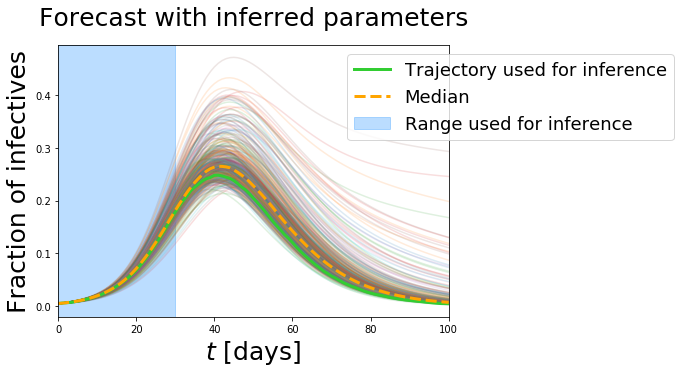

In [13]:
# Plot sum of A, Ia, Is populations

fontsize=25
#

ylabel=r'Fraction of infectives'
#

# Plot total number of symptomatic infectives
cur_trajectories_forecast = np.sum( trajectories_forecast[:,2*M:5*M,:] , axis = 1)
cur_mean_forecast = np.mean( cur_trajectories_forecast, axis=0)
percentile = 10
percentiles_lower = np.percentile(cur_trajectories_forecast,percentile,axis=0)
percentiles_upper = np.percentile(cur_trajectories_forecast,100-percentile,axis=0)
percentiles_median = np.percentile(cur_trajectories_forecast,50,axis=0)


data_array = np.load('SEAI5R_traj.npy')
cur_trajectory_underlying = np.sum( data_array[:,2*M:5*M] ,axis=1 )

#
# Plot trajectories
#
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.axvspan(0, Tf_inference, 
           label='Range used for inference',
           alpha=0.3, color='dodgerblue')
ax.set_title(r'Forecast with inferred parameters',
             y=1.05,
            fontsize=fontsize)
for i,e in enumerate(cur_trajectories_forecast):
    ax.plot(t_forecast,e/N,
            alpha=0.15,
           )
ax.plot(cur_trajectory_underlying/N,
        lw=3,
        color='limegreen',
       label='Trajectory used for inference')

ax.plot(t_forecast,percentiles_median/N,
                alpha=1,ls='--',
        color='orange',label='Median',
       lw=3)
''' # remove comments to plot percentiles
ax.plot(t_forecast,percentiles_lower/N,
                alpha=1,
        lw=2,
        label='Percentiles',
        ls='dotted',
        color='red',
       )
ax.plot(t_forecast,percentiles_upper/N,
                alpha=1,
        lw=2,
        color='red',
        ls='dotted',
       )
''';

ax.set_xlim(0,np.max(t_forecast))
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='upper right',bbox_to_anchor=(1.6,1),
          fontsize=18)
plt.show(fig)
#fig.savefig('inference_forecast.png',dpi=100,bbox_inches='tight')
plt.close(fig)